## Ejercicio N° 5 - Recommender systems

In [1]:
# En R o en python comparar distintos algoritmos de recomendación, en cuanto a forma de entrenamiento (training y testing, cv), 
# medición de accuracy.
# Comparar el resultado de algoritmos y sacar una conclusión.

## Librerías

In [36]:
# install.packages("recommenderlab")
# install.packages("data.table")
# install.packages("ggplot2")

library("recommenderlab")
library("data.table")
library("ggplot2")

## Lectura de datos

In [35]:
setwd("C:/Users/ig/Desktop/txm/tps/tp5")

# Dataset con usuarios
user <- fread("BX-Users.csv", encoding = "Latin-1")
names(user) <- c("userID", "Location", "Age")

# Dataset con ratings de libros
rating <- fread("BX-Book-Ratings.csv", encoding = "Latin-1")
names(rating) <- c("userID", "ISBN", "bookRating")

In [4]:
head(user)

userID,Location,Age
1,"nyc, new york, usa",NULL
2,"stockton, california, usa",18
3,"moscow, yukon territory, russia",NULL
4,"porto, v.n.gaia, portugal",17
5,"farnborough, hants, united kingdom",NULL
6,"santa monica, california, usa",61


In [5]:
head(rating)

userID,ISBN,bookRating
276725,034545104X,0
276726,0155061224,5
276727,0446520802,0
276729,052165615X,3
276729,0521795028,6
276733,2080674722,0


## Join de datos

In [6]:
# Comentario: este paso devuelve el mismo dataset que rating
df <- user[rating, on = "userID"]
df[ , c("Location", "Age") := NULL]

head(df)

userID,ISBN,bookRating
276725,034545104X,0
276726,0155061224,5
276727,0446520802,0
276729,052165615X,3
276729,0521795028,6
276733,2080674722,0


In [7]:
dim(df)

[1] 1149780       3

In [8]:
str(df)

Classes 'data.table' and 'data.frame':	1149780 obs. of  3 variables:
 $ userID    : int  276725 276726 276727 276729 276729 276733 276736 276737 276744 276745 ...
 $ ISBN      : chr  "034545104X" "0155061224" "0446520802" "052165615X" ...
 $ bookRating: int  0 5 0 3 6 0 8 6 7 10 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## Análisis exploratorio

### Distribución de ratings

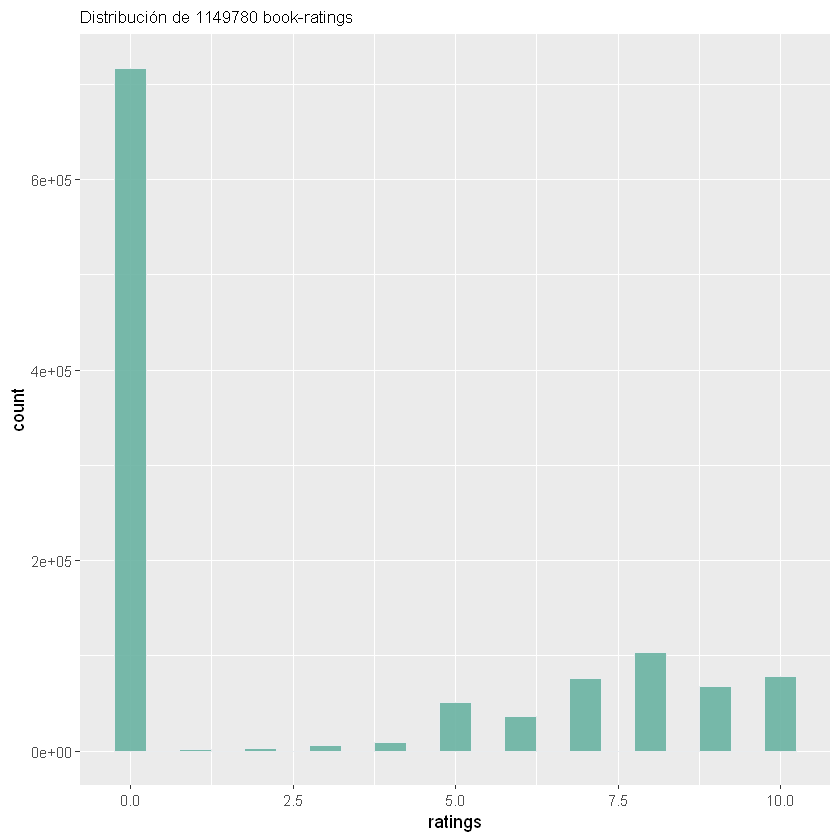

In [9]:
# Gráfico
p <- ggplot(data = df,  aes( x= bookRating)) +
  geom_histogram( binwidth= 0.5, fill="#69b3a2", color="#e9ecef", alpha=0.9) +
  ggtitle(paste0("Distribución de ",nrow(df) , " book-ratings" )) +
  theme(plot.title = element_text(size=10)) +
  xlab("ratings") +
  ylab("count")
    
p

Aproximadamente 62% de los raitings son 0 y hay muy pocos entre valores de 1, 2 y 3. Menor raiting significa peor calificación de los libros. 

### Distribución de ranking por libro

In [10]:
data <- df[, .N, by=.(ISBN)][ N > 50 ]
setorder(data, -N)

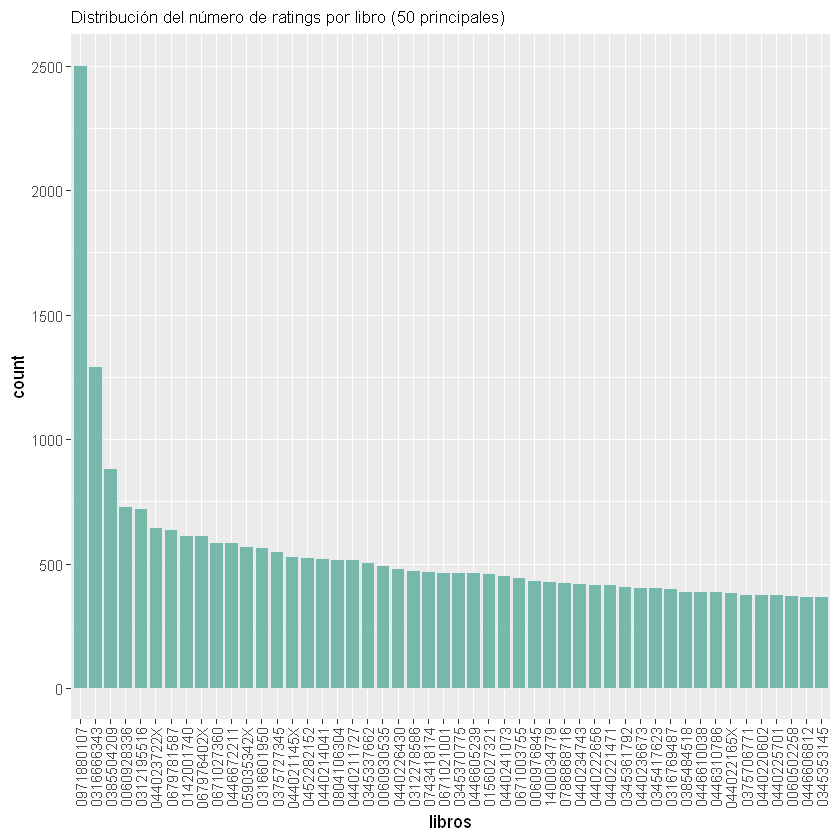

In [11]:
# Gráfico
p <- ggplot(data = data[1:50,],  aes( x= reorder(ISBN, -N), y=N)) +
  geom_bar( stat="identity", fill="#69b3a2", color="#e9ecef", alpha=0.9) +
  ggtitle("Distribución del número de ratings por libro (50 principales)") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  theme(plot.title = element_text(size=10)) +
  xlab("libros") +
  ylab("count")
    
p

In [12]:
head(data, 10)

ISBN,N
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723
044023722X,647
0679781587,639
0142001740,615
067976402X,614
0671027360,586


La mayoría de los libros recibieron menos de 5 calificaciones, y muy pocos libros tienen muchas calificaciones, aunque el libro más calificado ha recibido 2502 calificaciones.

### Distribución de rating por usuario

In [13]:
data <- df[, .N, by=.(userID)][ N > 50 ]
setorder(data, -N)

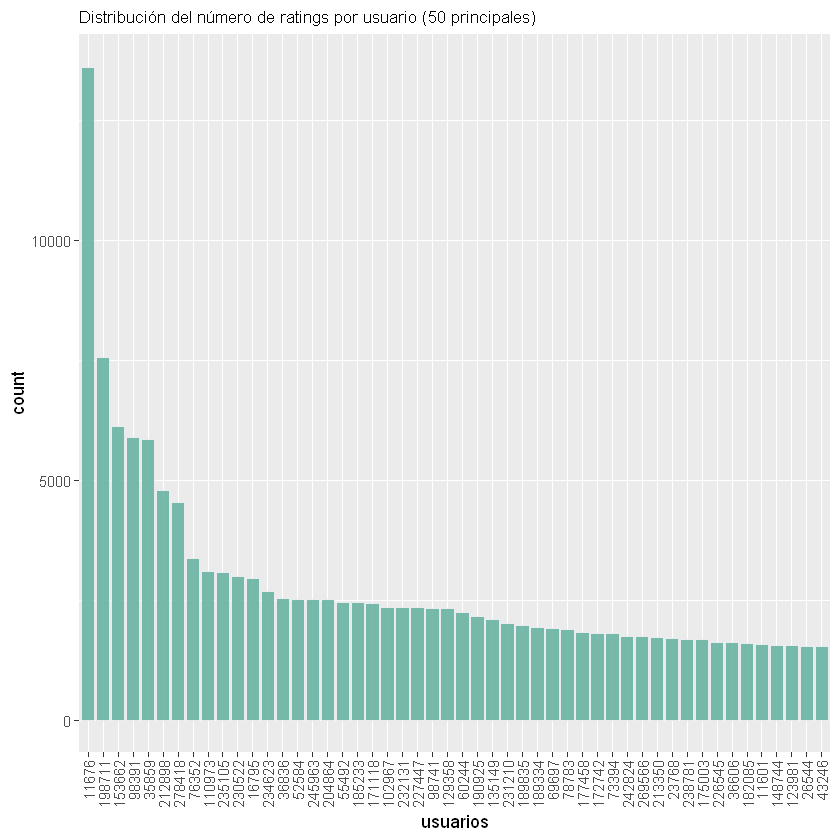

In [14]:
# Gráfico
p <- ggplot(data = data[1:50,],  aes( x= reorder(userID, -N), y=N)) +
  geom_bar( stat="identity", fill="#69b3a2", color="#e9ecef", alpha=0.9) +
  ggtitle("Distribución del número de ratings por usuario (50 principales)") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  theme(plot.title = element_text(size=10)) +
  xlab("usuarios") +
  ylab("count")
    
p

In [15]:
head(data, 10)

userID,N
11676,13602
198711,7550
153662,6109
98391,5891
35859,5850
212898,4785
278418,4533
76352,3367
110973,3100
235105,3067


La mayoría de los usuarios dieron menos de 5 calificaciones, y muy pocos usuarios dieron muchas calificaciones, aunque el usuario más productivo ha dado 13602 calificaciones.

Para reducir la dimensionalidad del conjunto de datos, se filtran los libros raramente calificadoss (con menos de 50 calificaciones) y también los usuarios que hicieron menos calificaciones (menos de 50).

In [16]:
# Se eliminan los items con menos de 50 calificaciones
min_book_ratings <- 50
df_new <- df[, count := .N, by=.(ISBN)][ count > min_book_ratings,  ]

# Se eliminan (filtran) los usuarios que calificaron menos de 50 veces
min_user_ratings <- 50
df_new <- df_new[, count := .N, by=.(userID)][ count > min_user_ratings,  ]
df_new[, count := NULL]

paste0("Dimensiones del dataset original: (", nrow(df),     ", ", ncol(df),     ")")
paste0("Dimensiones del dataset nuevo:    (", nrow(df_new), ", ", ncol(df_new), ")")

[1] "Dimensiones del dataset original: (1149780, 4)"

[1] "Dimensiones del dataset nuevo:    (93745, 3)"

## Formato realRatingMatrix 
Primero se adapta el dataset procesado al formato requerido para poder evaluar los distintos sistemas de recomendación

In [31]:
r <- as(df_new, "realRatingMatrix")
r

# Vista previa primeros 25 libros para los primeros 20 usuarios
head(getRatingMatrix(r)[,1:25], 20)

781 x 2125 rating matrix of class 'realRatingMatrix' with 93745 ratings.

   [[ suppressing 25 column names '000649840X', '002026478X', '0020442203' ... ]]


20 x 25 sparse Matrix of class "dgCMatrix"
                                                         
243  . . . . .  . . . . . .  . . . . . . . . . . . .  . .
254  . . . . .  0 . . . . .  . . . . . . . . . . . .  . .
882  . . . . .  . . . . . .  . . . . . . . . . . . .  . 0
2276 . . . . .  . . . . . .  . . . . . . . . . . . .  . .
2766 . . . . .  . . . . . .  . . . . . . . . . . . .  0 .
3363 . . . 0 0  . . . . . 0  0 . . . 0 . . . . . . .  . 0
4017 . . . . . 10 . . . . .  . . . . . 9 . . . . . .  . .
5903 . . . . .  . . . . 0 .  . . . . . . . . . . . .  . .
6251 . . . . .  . . 0 . . .  . . . . . . 0 . . . . . 10 .
6323 . . . . .  . . . . . .  . . . . . . . . . . . .  . .
6543 . . . . .  . . . . . .  . . . . . . . . . . . .  . .
6563 . . . . .  . . . . 6 .  . . . . . . . . . . 8 .  . .
6575 . . . . 0  9 . . . 0 .  . . . 0 . . . . . 8 . .  . 8
7125 . . . . .  . . . . . 0  8 . . . . . . . . . . .  . .
7158 . . . . .  . . . . . .  . . . . . . . . . . . .  . .
7346 . . . . 8  . . . . 0 .  

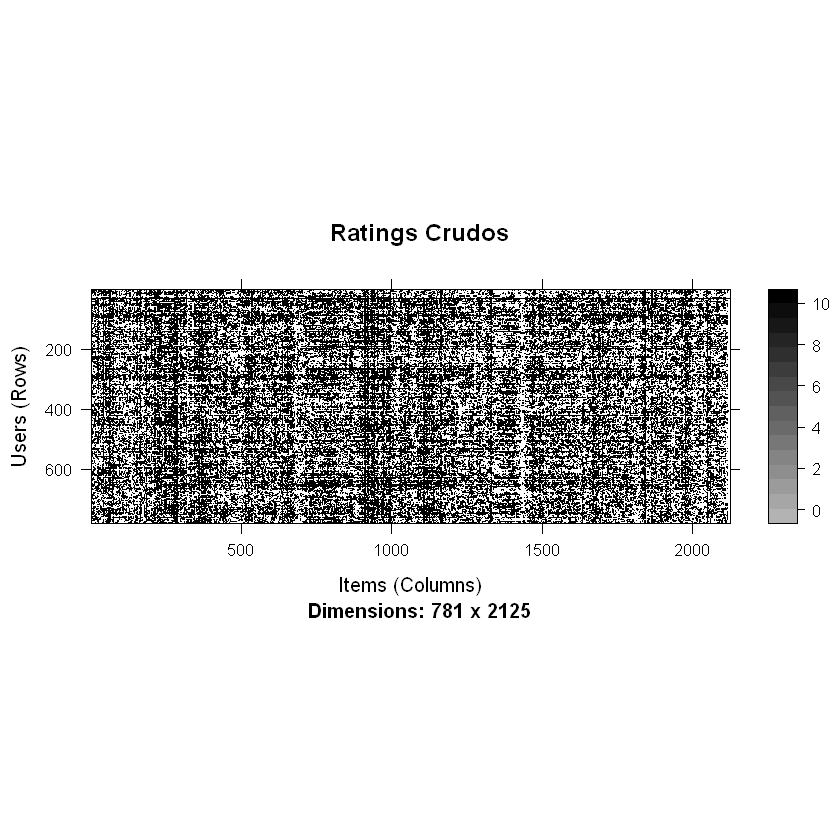

In [18]:
# Matriz de raitings
print(image(r, main = "Ratings Crudos"))

## Comparación de modelos
Se evalúan diferentes modelos mediante Train/Test y Cross-Validation

### Algoritmos a evaluar

In [32]:
algorithms <- list(
  "rating-based LF"   = list(name="ALS"    , param=list(normalize ="center")),
  "random items"      = list(name="RANDOM" , param=NULL),
  "popular items"     = list(name="POPULAR", param=NULL),
  "user-based CF"     = list(name="UBCF"   , param=list(nn = 50)),
  "item-based CF"     = list(name="IBCF"   , param=list(method = "Cosine", k =  50)),
  "SVD approximation" = list(name="SVD"    , param=list(k =  50))
)

### Evaluación mediante Train/Test

In [20]:
# Se trabaja con given = 50 que es el valor mínimo elegido de calificaciones de un usuario en df_new
# A partir de 5 se considera un raiting positivo
# 75 % train y 25 % Test
set.seed(123)
scheme_sp <- evaluationScheme(r, method = "split", train = 0.75, given = 50, goodRating = 5)
scheme_sp

Evaluation scheme with 50 items given
Method: 'split' with 1 run(s).
Training set proportion: 0.750
Good ratings: >=5.000000
Data set: 781 x 2125 rating matrix of class 'realRatingMatrix' with 93745 ratings.

In [21]:
# Se ajusta modelo
results <- evaluate(scheme_sp, algorithms, type = "topNList", n=c(1, 3, 5, 10, 15, 20, 30))

ALS run fold/sample [model time/prediction time]
	 1  [0sec/46.15sec] 
RANDOM run fold/sample [model time/prediction time]
	 1  [0sec/0.51sec] 
POPULAR run fold/sample [model time/prediction time]
	 1  [0.02sec/0.83sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.02sec/2.28sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [83.79sec/0.34sec] 
SVD run fold/sample [model time/prediction time]
	 1  [0.84sec/0.35sec] 


#### Curva ROC
La curva ROC se define por la tasa positiva verdadera (TPR) y la tasa positiva falsa (FPR).

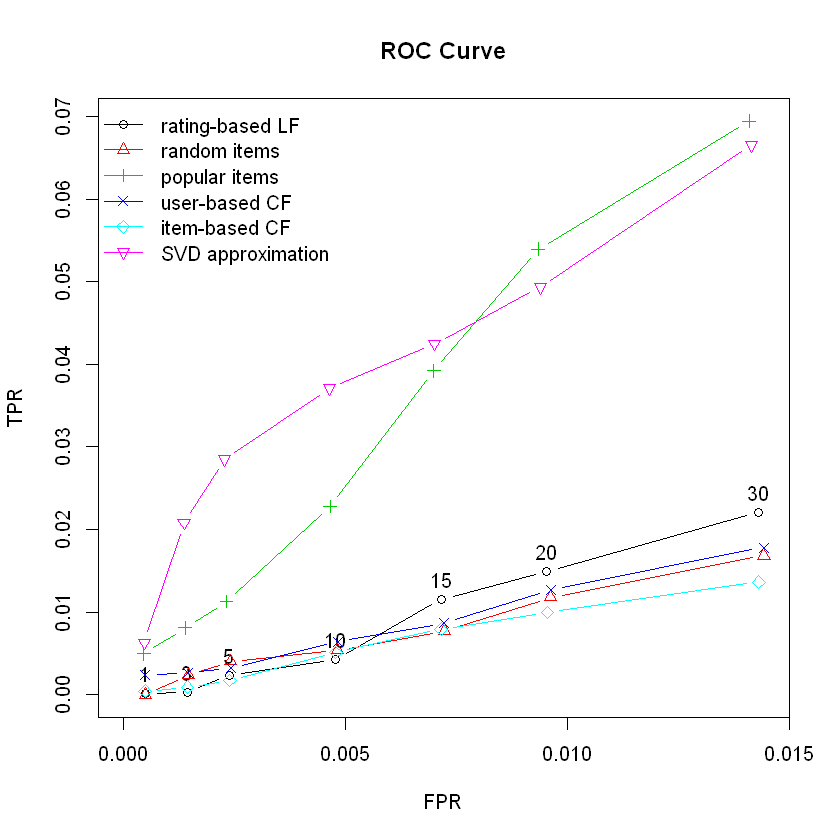

In [22]:
# Gráfico
plot(results, y = "ROC", annotate = 1, legend="topleft")
title("ROC Curve")

Con menos de 15 recomedaciones el modelo basado en factorización matricial (SVD approximation) tiene mejor rendimiento ya que alcanza el TPR más alto para cualquier nivel dado de FPR. Es decir, que el modelo está produciendo el mayor número de recomendaciones relevantes (verdaderos positivos) para el mismo nivel de recomendaciones no relevantes (falsos positivos).

Con algo más de 15 recomendaciones empieza a ser más efectivo el modelo basado en la popularidad de items (popular items)

#### Curva Precision vs Recall
La precisión muestra cuán sensibles son los modelos a los Falsos Positivos mientras que Recall analiza la sensibilidad de los modelos frente a los Falsos Negativos.

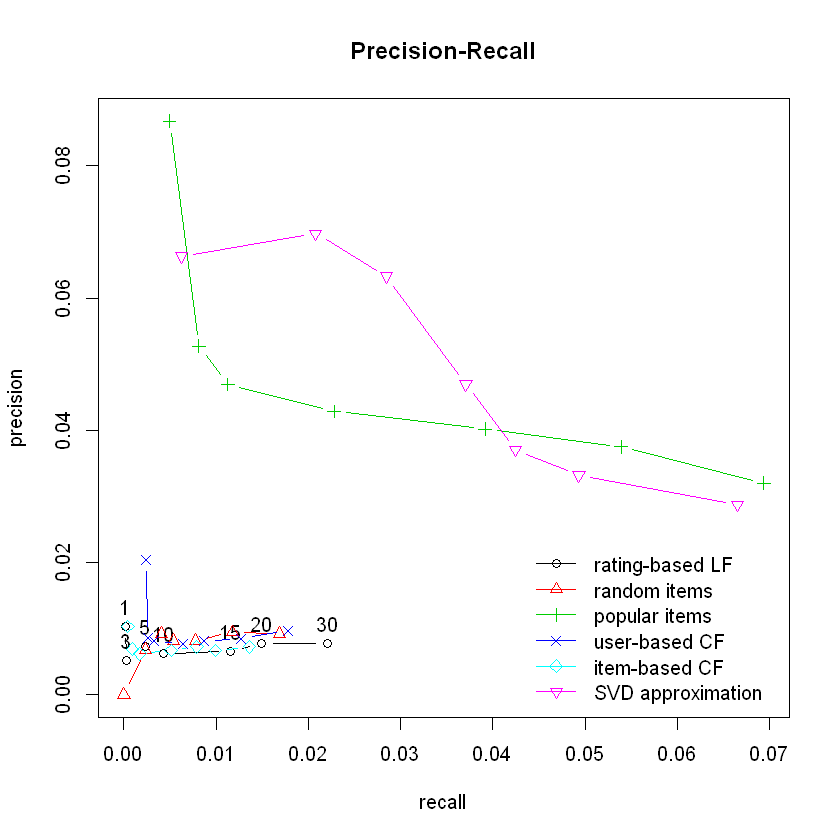

In [23]:
# Gráfico
plot(results, y = "prec/rec", annotate=1)
title("Precision-Recall")

Con menos de 5 recomendaciones el gráfico muestra como los modelos "SVD approximation" y "popular items" tienen mayor precisión a igual Recall, es decir, sus predicciones entregan menor número de Falsos Positivos. A partir de ahí (más de 5 recomendaciones) también se nota una reducción en los Falsos Negativos (maximización del Recall) para la misma Precisión. Por lo tanto, ambos modelos se comportan mejor que el resto y se ratifican los resultados observados en la curva ROC.

#### Accuracy de los mejores modelos
Se calcula el accuracy de los modelos "SVD approximation" y "popular items" los cuáles parecen ser más efectivos, para una cantidad de 10 recomendaciones

In [24]:
#  Número de recomendaciones
items_to_recommend <- 10

In [25]:
eval_recommender <- Recommender(data = getData(scheme_sp, "train"), method = "SVD", parameter = NULL)

eval_prediction  <- predict(object = eval_recommender,
                            newdata = getData(scheme_sp, "known"),
                            n = items_to_recommend,
                            type = "ratings")

eval_accuracy    <- calcPredictionAccuracy(x = eval_prediction,
                                           data = getData(scheme_sp, "unknown"),
                                           byUser = TRUE)
head(eval_accuracy)

,RMSE,MSE,MAE
243,2.149145,4.618825,2.144354
254,3.845667,14.789158,3.129585
882,2.191149,4.801135,2.191149
6251,3.385021,11.458370,2.431132
7915,3.390256,11.493837,3.013870
8067,3.770585,14.217311,3.754993


In [26]:
eval_recommender <- Recommender(data = getData(scheme_sp, "train"), method = "POPULAR", parameter = NULL)

eval_prediction  <- predict(object = eval_recommender,
                            newdata = getData(scheme_sp, "known"),
                            n = items_to_recommend,
                            type = "ratings")

eval_accuracy    <- calcPredictionAccuracy(x = eval_prediction,
                                           data = getData(scheme_sp, "unknown"),
                                           byUser = TRUE)
head(eval_accuracy)

,RMSE,MSE,MAE
243,2.212884,4.896856,2.189715
254,3.535203,12.497659,2.856011
882,1.685956,2.842447,1.685956
6251,3.238855,10.490179,2.365325
7915,3.439592,11.830794,3.097990
8067,3.640442,13.252817,3.536765


Para 10 recomendaciones el modelo basado en factorización matricial (SVD) se comportó mejor (menor error) que el modelo basado en la popularidad de items (POPULAR), pero la diferencia es mínima.

### Evaluación mediante Cross-Validation

In [27]:
# Se trabaja con given = 50 que es el valor mínimo elegido de calificaciones de un usuario en df_new
# A partir de 5 se considera un raiting positivo
# K-fold = 5
set.seed(123)
scheme_cv <- evaluationScheme(r, method="cross", k = 5, given = 50, goodRating = 5)
scheme_cv

Evaluation scheme with 50 items given
Method: 'cross-validation' with 5 run(s).
Good ratings: >=5.000000
Data set: 781 x 2125 rating matrix of class 'realRatingMatrix' with 93745 ratings.

In [28]:
# Se ajusta modelo
results <- evaluate(scheme_cv, algorithms, type = "topNList", n=c(1, 3, 5, 10, 15, 20, 30))

ALS run fold/sample [model time/prediction time]
	 1  [0sec/45.22sec] 
	 2  [0sec/44.92sec] 
	 3  [0sec/44.49sec] 
	 4  [0sec/44.83sec] 
	 5  [0sec/43.95sec] 
RANDOM run fold/sample [model time/prediction time]
	 1  [0sec/0.33sec] 
	 2  [0.01sec/0.3sec] 
	 3  [0sec/0.35sec] 
	 4  [0sec/0.35sec] 
	 5  [0sec/0.51sec] 
POPULAR run fold/sample [model time/prediction time]
	 1  [0.01sec/0.66sec] 
	 2  [0.01sec/0.58sec] 
	 3  [0.02sec/0.6sec] 
	 4  [0sec/0.59sec] 
	 5  [0sec/0.61sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/1.74sec] 
	 2  [0.01sec/1.78sec] 
	 3  [0sec/1.88sec] 
	 4  [0.01sec/1.92sec] 
	 5  [0.01sec/1.83sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [70.32sec/0.21sec] 
	 2  [63.99sec/0.52sec] 
	 3  [64.16sec/0.24sec] 
	 4  [57.92sec/0.24sec] 
	 5  [61.01sec/0.28sec] 
SVD run fold/sample [model time/prediction time]
	 1  [0.85sec/0.47sec] 
	 2  [0.77sec/0.29sec] 
	 3  [0.74sec/0.26sec] 
	 4  [0.84sec/0.26sec] 
	 5  [0.9sec/0.28sec] 


#### Curva ROC

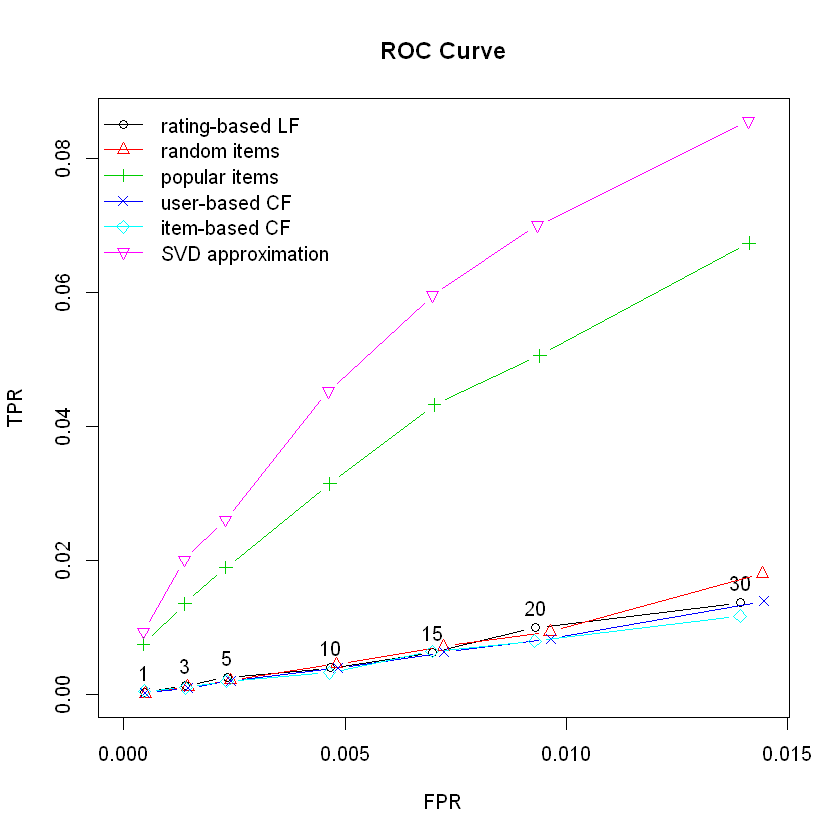

In [29]:
plot(results, y = "ROC", annotate = 1, legend="topleft")
title("ROC Curve")

En el gráfico el modelo "SVD approximation" tiene mejor rendimiento que el modelo "popular items". Pero ambos, tienen un desempeño sobresaliente respecto al resto.

#### Curva Precision vs Recall

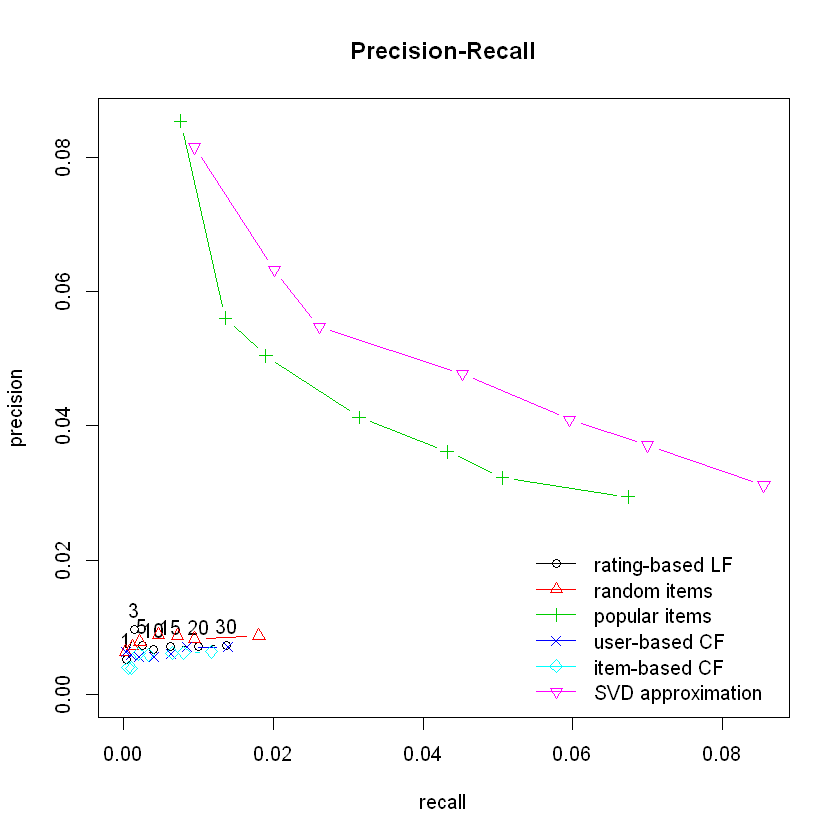

In [30]:
# Precision / Recall 
plot(results, y = "prec/rec", annotate=1)
title("Precision-Recall")

Nuevamente, se observa una mejor efectvidad del modelo basado en factorización matricial (SVD) frente al modelo basado en la popularidad de items. 

#### Se puede concluir que el modelo basado en factorización matricial (SVD) es el que ofrece mejor desempeño como recomendador, seguido por el modelo basado en la popularidad de items con un rendimiento levemente inferior mientras que el resto demostró una efectividad significativamente más baja. 